In [1]:
import sys
sys.path.append('../../')

import numpy as np

from src.mechanism.single_item import SingleItemAuction
from src.game import Game
from src.strategy import Strategy

from src.learner.frank_wolfe import FrankWolfe
from src.learner.soma import SOMA
from src.learner.soda import SODA

from src.util.metrics import *

**Setting**
create specific Single Item Auction setting

In [21]:
# parameter mechanism
bidder = ['1']*2
o_space = {i: [0.00, 1.0] for i in bidder}
a_space = {i: [0.05, 1.0] for i in bidder}

param_prior = {
    'distribution':'uniform',
    'mu':0.5,
    'sigma':0.15,
    }
param_util = {
    'payment_rule': 'first_price', 
    'tie_breaking': 'lose', 
    'utility_type': 'ROI',
    'budget': 1.01,
    }

# parameter approximation game
n = 128
m = 128

# create mechanism
mechanism = SingleItemAuction(bidder, o_space, a_space, param_prior, param_util)

# create approximation game
game = Game(mechanism, n, m)
if not mechanism.own_gradient:
    game.get_utility(mechanism)



own gradient


**Learner**
Specify Learning Algorithm

In [22]:
# parameter learner
max_iter = int(5e3)
tol = 1e-5
stop_criterion = 'util_loss'
regularizer = 'euclidean'
steprule_bool = True
eta = 1
beta = 1/2

#learner = SODA(max_iter, tol, stop_criterion, regularizer, steprule_bool, eta, beta)
#learner = SOMA(max_iter, tol, stop_criterion, regularizer, steprule_bool, eta, beta)
learner = FrankWolfe(max_iter, tol, stop_criterion, 'standard', False, eta, beta)

Run Learning Algorithm

In [23]:
#create and initialize strategies
strategies = {}
for i in game.set_bidder:
    strategies[i] = Strategy(i, game)
    strategies[i].initialize('equal')
    #strategies[i].initialize('matrix', {"init_matrix": bne})
    
# run soda
learner.run(mechanism, game, strategies, disable_tqdm_bool=False, print_result_bool=True, save_history_bool=True)

 50%|██████████          | 2.51k/5.00k [00:03<00:03, 746it/s]

Convergence after 2506 iterations
Value of stopping criterion (util_loss) 1e-05


Visualization of the learning process and the final result

In [24]:
def bne_ql(x, N, r):
    if x <= r:
        return r
    else:
        return (N-1)/N*x + 1/N * (r**N)/(x**(N-1))

def bne_roi(x, N, r):
    if x <= r:
        return r
    if N == 2:
        return x/(-np.log(r)+np.log(x)+1)
    elif N == 5:
        return -3*x**4/(r**3 - 4*x**3)

bne = [bne_roi(xi, len(bidder), 0.05) for xi in strategies['1'].o_discr]

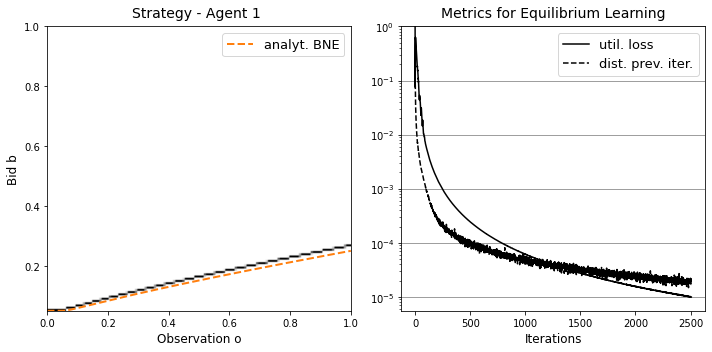

In [25]:
strategies['1'].plot(metrics=True, beta=bne)